In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


LOAD IN PRETRAINED RESNET18

In [2]:
"""
The original ResNet-18 architecture is introduced in:
"Deep Residual Learning for Image Recognition" by He et al. (https://arxiv.org/abs/1512.03385)
Pre-trained model is sourced from PyTorch's torchvision library (https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18)
"""

from torchvision import models
import torch

model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 74.7MB/s]


CONSTRUCTING TRAIN AND TEST DATALOADERS

In [4]:
import zipfile
import pandas as pd
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision


# specify file paths [for colab environment]
img_path = "/content/drive/MyDrive/MLEnggCoop_TakeHomeAssignment_Docket/training_data/images.zip"
labels_path = "/content/drive/MyDrive/MLEnggCoop_TakeHomeAssignment_Docket/training_data/labels.csv"
data = pd.read_csv(labels_path)

# define image dataset loading + structure
class ImageDataset(Dataset):
    def __init__(self, zip_file, csv_data, transform=None):
        self.zip_file = zip_file
        self.csv_data = csv_data
        self.transform = transform
        self.label_map = {"empty": 0, "filled": 1}

    def __len__(self):
        return len(self.csv_data)

    def __getitem__(self, idx):
        img_path = self.csv_data.iloc[idx, 0]
        label = self.csv_data.iloc[idx, 1]
        label = self.label_map[label]

        # Load the image from zip file
        with zipfile.ZipFile(self.zip_file, 'r') as archive:
            with archive.open(img_path) as file:
                image = Image.open(BytesIO(file.read())).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# image augmentation and standardization
transform = transforms.Compose(
    [
        torchvision.transforms.Resize((512, 512)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        torchvision.transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

# split into train / test
dataset = ImageDataset(zip_file=img_path, csv_data=data, transform=transform)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
import torch
import time
from tqdm import tqdm
import os

# Device setup
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Compute accuracy
def compute_accuracy(model, loader):

    total_correct = 0
    model.to(device)  # Put the model on the right device
    model.eval()  # Enable eval mode on the model

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to the correct device
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
    return total_correct / len(loader.dataset)

# Training loop with cross entropy loss
def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path=None, scheduler=None):

    if path and not os.path.exists(path):
        os.makedirs(path)

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()

        for inputs, labels in tqdm(train_loader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if path:
            torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')

        end_time = time.perf_counter()
        duration = end_time - start_time

        # Calculate train and validation accuracy
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)

        current_lr = optimizer.param_groups[0]['lr']
        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.6f}',
              f'val acc: {val_acc:.6f}', sep='\t')

# Parameter counting function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

SPECIFY PARAMETERS + TRAINING LOOP

In [6]:
from torch.optim import lr_scheduler
from torch.optim import Adam

# Calculate class weight to address class imbalance
total_samples = len(train_dataset)
num_filled_samples = sum(1 for _, label in train_dataset if label == 1)
num_empty_samples = total_samples - num_filled_samples
weight_0 = num_empty_samples / total_samples  # Weight for class 0 (empty)
weight_1 = num_filled_samples / total_samples  # Weight for class 1 (filled)
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32).to(device)

# specify parameters
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
checkpoint_path = "/content/drive/MyDrive/MLEnggCoop_TakeHomeAssignment_Docket/src/checkpoints"
num_epochs = 5

In [7]:
train(model, train_loader, test_loader, num_epochs, criterion, optimizer, path=checkpoint_path, scheduler=scheduler)

epoch  1	loss: 4.560	time: 46.754	train acc: 0.990057	val acc: 0.986755


epoch  2	loss: 0.573	time: 46.056	train acc: 0.998580	val acc: 1.000000


epoch  3	loss: 0.408	time: 43.809	train acc: 1.000000	val acc: 0.996689


epoch  4	loss: 0.182	time: 45.209	train acc: 1.000000	val acc: 1.000000


epoch  5	loss: 0.155	time: 46.301	train acc: 1.000000	val acc: 1.000000


GENERATE SUMMARY STATISTICS

In [8]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
import numpy as np

def compute_metrics(model, loader):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # generate prediction
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            # For binary AUROC, we need probability of class 1
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class

            # Store predictions
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Compute AUROC
    auroc = roc_auc_score(all_labels, all_probs)
    print(f'AUROC: {auroc:.4f}')

    # Compute precision and recall
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    print(f'\nPrecision: {precision:.4f}')
    print(f'\nRecall: {recall:.4f}')

    # print confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f'\nConfusion Matrix:\n{conf_matrix}')



In [9]:
compute_metrics(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


AUROC: 1.0000

Precision: 1.0000

Recall: 1.0000

Confusion Matrix:
[[101   0]
 [  0 201]]


GENERATE SAMPLE CLASSIFICATIONS [TRANSFORMED IMAGES]

In [10]:
import random
import matplotlib.pyplot as plt

# Mapping for the labels
label_map = {0: 'empty', 1: 'full'}

# Function to display images with predicted and true labels
def display_random_images(model, loader, num_images=9):
    model.to(device)
    model.eval()

    images = []
    true_labels = []
    predicted_labels = []

    # Collect images + labels
    all_images = []
    all_labels = []
    for inputs, labels in loader:
        all_images.extend(inputs.cpu())
        all_labels.extend(labels.cpu().numpy())

    # Randomly select indices
    indices = random.sample(range(len(all_images)), num_images)

    # Process and predict for each of the randomly selected images
    with torch.no_grad():
        for idx in indices:
            image = all_images[idx]
            label = all_labels[idx]

            input_image = image.unsqueeze(0).to(device)

            # Model prediction
            output = model(input_image)

            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

            images.append(image)
            true_labels.append(label_map[label])
            predicted_labels.append(label_map[predicted_label])

    # Plot the images along with predicted and true labels
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i in range(num_images):
        image = images[i].permute(1, 2, 0)
        true_label = true_labels[i]
        predicted_label = predicted_labels[i]

        axes[i].imshow(image.numpy())
        axes[i].set_title(f"True: {true_label}, Pred: {predicted_label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


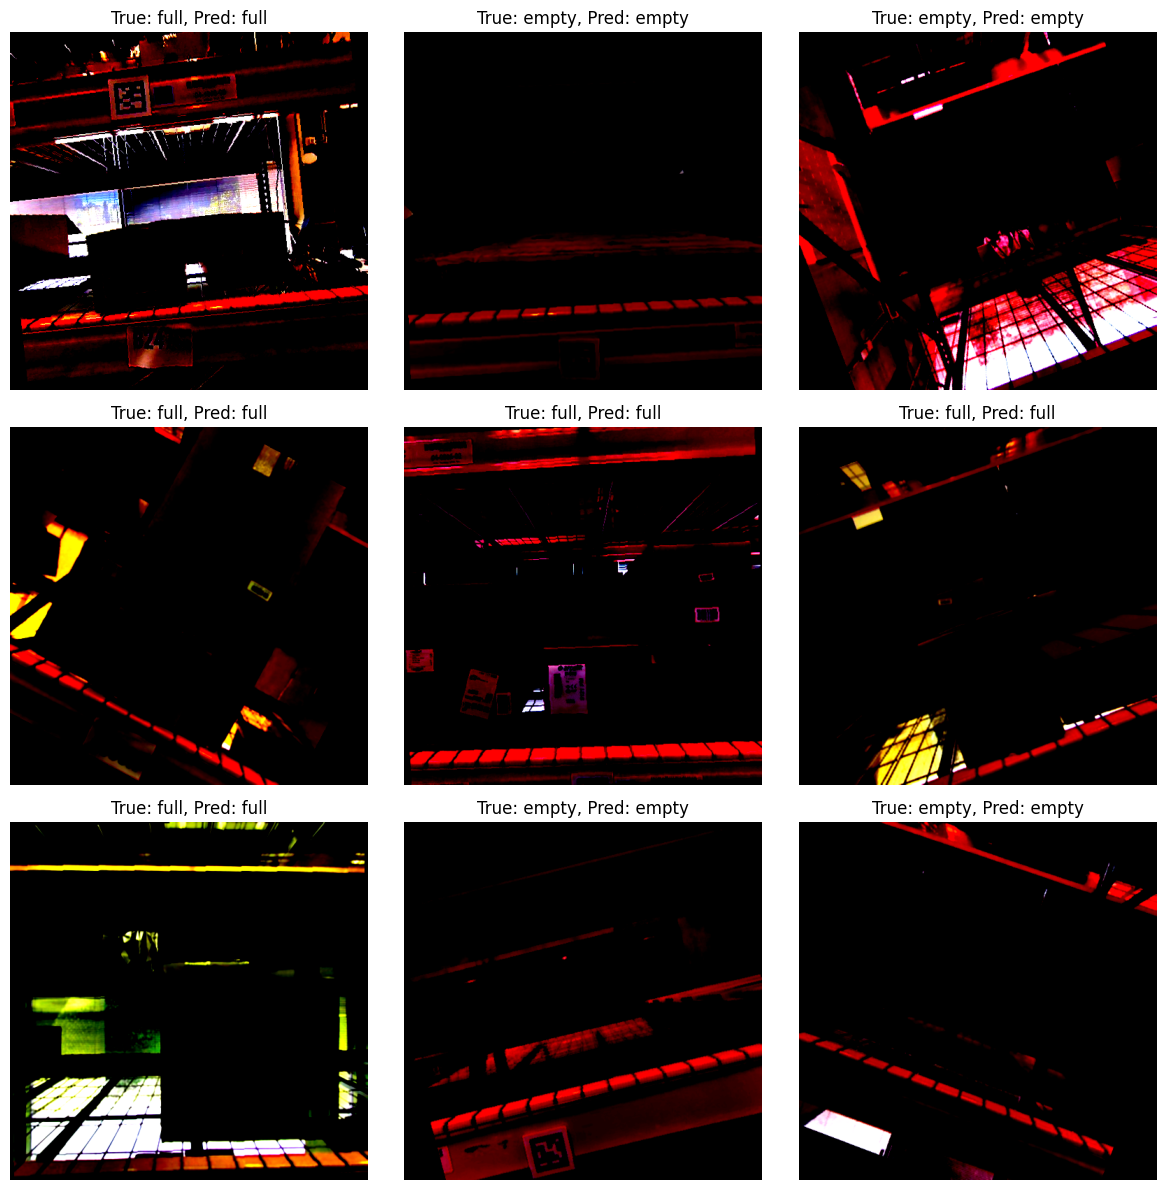

In [11]:
display_random_images(model, test_loader, num_images=9)